# Week 16. Robustness  
  
Deep learning has been widely applied to various computer vision tasks with excellent performance. Prior to the realization of the adversarial example phenomenon by Biggio et al., Szegedy et.al, model performance on clean examples was the main evaluation criteria. However, in security-critical applications, robustness to adversarial atttacks has emerged as a critical factor.    

In this part, we would engage into experiments about the robustness of neural networks.   

We would introduce one basic attack method which adds perturbation to clean images and one newest defense method calling fast adversarial training.  

Our experiments are based on MNIST and the model we would use here is LeNet. Since the dataset is small and the network is simple, you can either run the code on the GPU or your personal PC.  

Edited by Felix Xue.

# Outline  
1. Adversarial attack v.s. Defense  
    - adversarial examples  
    - attack scenarios  
    - attack methods 
    - defense methods
2. Attack: FGSM
3. Defense: Adversarial training  
4. Practise(Another Dataset)

![map](imgs/adversarial.png)

# Adversarial Attack v.s. Defense  

## Adversarial examples  
An adversarial example is a sample of input data which has been modified very slightly in a way that is intended to cause a machine learn classifier to misclassify it.    

## Common attack scenarious  
Scenarious of possible adversarial attacks can be categorized along different dimensions.  

First of all, attacks can be classified **by the type of outcome the adversary desires**:  
- Non-targetd attack. In this case adversary's goal is to cause the classifier to predict any incorrect label. The specific incorrect label does not matter.  
- Targeted attack. In this case the adversary aims to change the classifier's prediction to some specific target class.  

Second, attack scenarious can be classified **by the amout of knowledge the adversary has about the model**:  
- White box. The adversary has full knowledge of the model including model type, model architecture and values of all parameters and trainable weights.  
- Blackbox with probing. The adversary does not know vary much about the model, but can probe or query the model, i.e. feed some inputs and observe outputs.  
- Blackbox without probing. Ihe adversary has limited or no knowledge about the model under attack and is not allowed to probe or query the model while constructing adversarial examples.  

Third, attacks can be classified **by the way adversary can feed data into the model**:  
- Digital attack. The adversary has direct access to the actual data fed into the model. i.e. uploads a PNG file to a web service, and intentionally designs the file to be read incorrectly.  
- Physical attack. The adversary does not have direct access to the digital representation of provided to the model. Instead, the model is fed input obtained by sensors such as a camera or microphone. The adversary is able to place objects in the physical environment seen by the camera or produce sounds heard by the microphone.  

## Overveiw of Attack methods  
- White box digital attacks  
- Black box attacks  
It was observed that adversarial examples generlize between different models. In other words, a significant fraction of adversarial examples which fool one model are able to fool a different model. This property is called "transferability" and is used to craft adversarial examples in the black box scenario.    


## Overview of Defenses  
- Image preprocessing and denoising
- JPEG compression  
- Gradient masking  
- Detecting and refusing  
- Adversarial training.

# Attack

### Fast Gradient Sign Attack  

One of the fist and most popular adversarial attacks to date is referred to as the *Fast Gradient Sign Attack(FGSM)* and is described by Goodfellow et.al. in [Explaining and Harnessing Adversarial
Examples](<https://arxiv.org/abs/1412.6572>). The attack is remarkably powerful, and yet intuitive. It is designed to attack neural networks by leveraging the way they learn, *gradients*. The idea is simple, rather than working to minimize the loss by adjusting the weights based on the backpropagated gradients, the attack *adjusts the input data to maximize the loss* based on the same backpropagated gradients. In other words, the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.   

Before we jump into the code, let's look at the famous **FGSM** panda example and extract some notation.  

![fgsm_panda](imgs/fgsm.png)  

From the figure, $\mathbf{x}$ is the original input image
correctly classified as a “panda”, $y$ is the ground truth label
for $\mathbf{x}$, $\mathbf{\theta}$ represents the model
parameters, and $J(\mathbf{\theta}, \mathbf{x}, y)$ is the loss
that is used to train the network. The attack backpropagates the
gradient back to the input data to calculate
$\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. Then, it adjusts
the input data by a small step ($\epsilon$ or $0.007$ in the
picture) in the direction (i.e.
$sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$) that will
maximize the loss. The resulting perturbed image, $x'$, is then
*misclassified* by the target network as a “gibbon” when it is still
clearly a “panda”.

  
    
    
    

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch  
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import resnet
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
start

Implementation  
----------------

Int this section, we will discuss the input parameters for the tutorial,
define the model under attack, then code the attack and run some tests.  


Inputs  
------  

There are only three inputs for this tutorial, and are defined as 
follows:  
-  **epsilons** - List of epsilon values to use for the run. It is 
   important to keep 0 in the list because it represents the model 
   performance on the original test set. Also, intuitively we would
   expect the larger the epsilon, the more noticeable the perturbations
   but the more effective the attack in terms of degrading model 
   accuracy. Since the data range here in $[0,1]$, no epsilon
   value should exceed 1.
-  **pretrained_model** - Path to the pretrained MINST model which was
   trained with resnet (source code located at resnet.py) and lenet.  
-  **use_cuda** - boolean flag to use CUDA if desired and available.
   Note, a GPU with CUDA is not critical for this tutorial as a CPU will
   not take much time.  

<p style="color:red; font-weight:700; font-size: 20px;">Please try to detect available gpu device with torch.cuda</p>

In [8]:
epsilons = [0, .05, .15, .25]
# epsilons = [0, .05, .1, .15, .2, .25, .3]

# Use pretrained model or not
# pretrained_model = "data/mnist_cnn.pt"  

# Both of the network and dataset are simple, so we can use small number of epochs.
epochs = 3


use_cuda = True  
# Define what device we are using
# Code here
print("CUDA Available: ", torch.cuda.is_available())  
# hint: torch.cuda.is_available()

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# device = torch.device("cuda" if (use_cuda and 'code' here) else "cpu")

CUDA Available:  True


## Load Dataset  

To accelerate training process, we use the raw test dataset as our training dataset.   

Also, you can train model with the original training dataset.  

In [20]:
# MNIST dataloader
def dataset_mnist(train_batch=32, test_batch=1):
    # MNIST Train dataset
#     train_loader = torch.utils.data.DataLoader(
#         datasets.MNIST('./data/mnist', train=True, download=False,
#                        transform=transforms.Compose([transforms.ToTensor()])),
#             batch_size=train_batch, shuffle=True)
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data/mnist', train=False, download=True, 
                       transform=transforms.Compose([transforms.ToTensor()])),
            batch_size=train_batch, shuffle=True)

    # MNIST Test dataset and dataloader declaration  
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data/mnist', train=False, download=True, 
                       transform=transforms.Compose([transforms.ToTensor()])),
            batch_size=test_batch, shuffle=False)
    return train_loader, test_loader

Model Under Attack  
------  

As mentioned, the model under attack is the same MNIST model from `resnet.py`. You may
train and save your own MINST model or you can use the provided model.
The *Net definition* and test dataloader here have benn copied from 
the MNIST example. The purpose of this section is to define the 
model and dataloader, then initialize the model and load the pretrained
weights.

In [21]:
# Train a traditional classifier with resnet or use the pretrained one.
raw_resnet_path = './data/mnist_resnet.pt'

## Train a traditional classifier      

In [22]:
# Train model  
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train() # set model state to `train`
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
# Test model  
def test(model, device, criterion, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))  
    
def raw_train(save_name=raw_resnet_path):
    '''
    Main function to train and save the model under atttack.
    
    params:
        save_name: The model to be saved.
    '''
    train_loader, test_loader = dataset_mnist()
    # Initialize the network
    model = resnet.ResNet18().to(device)
    
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    
    # Define the criterion 
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, criterion, test_loader)
    
    # Save model
    torch.save(model.state_dict(), save_name)
    print('Model saved at ', save_name)


<p style="color:red; font-weight:700; font-size: 20px;">Call this function, you can get a well trained classifier with accuracy up to 95+%.</p>  
Or you can use the pretrained one.

In [23]:
raw_train()
# Call this function, you can get a well trained classifier with accuracy up to 95+%.  

Processing...
Done!
Train Epoch: 1 [0/10000 (0%)]	Loss: 3.141578
Train Epoch: 1 [3200/10000 (32%)]	Loss: 0.461507
Train Epoch: 1 [6400/10000 (64%)]	Loss: 0.111834
Train Epoch: 1 [9600/10000 (96%)]	Loss: 0.199889

Test set: Average loss: 0.2388, Accuracy: 9308/10000 (93%)

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.105005
Train Epoch: 2 [3200/10000 (32%)]	Loss: 0.106824
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.029733
Train Epoch: 2 [9600/10000 (96%)]	Loss: 0.048218

Test set: Average loss: 0.0888, Accuracy: 9697/10000 (97%)

Train Epoch: 3 [0/10000 (0%)]	Loss: 0.016083
Train Epoch: 3 [3200/10000 (32%)]	Loss: 0.162881
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.183885
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.127461

Test set: Average loss: 0.0483, Accuracy: 9860/10000 (99%)

Model saved at  ./data/mnist_resnet.pt


FGSM Attack  
------  

Now, we can define the function that creates the adversarial examples by
perturbing the original inputs. The ``fgsm_attack`` function takes three
inputs, *image* is the original clean image ($x$), *epsilon* is
the pixel-wise perturbation amount ($\epsilon$), and *data_grad*
is gradient of the loss w.r.t the input image
($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$). The function
then creates perturbed image as

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.  

<p style="color:red; font-weight:700; font-size: 20px;">Please try to finish the attack code with the information above.</p>

In [26]:
# FGSM attack code  
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient  
    sign_data_grad = data_grad.sign()  
    # Create the perturbed image by adjusting each pixel of the input image  
    
    # code here    
    perturbed_image = image + epsilon * sign_data_grad
    
    # Note: Adding clipping to maintain [0,1] range  
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image  
    return perturbed_image

Testing Function
------

Finally, the central result of this tutorial comes from the ``test``
function. Each call to this test function performs a full test step on
the MNIST test set and reports a final accuracy. However, notice that
this function also takes an *epsilon* input. This is because the
``test`` function reports the accuracy of a model that is under attack
from an adversary with strength $\epsilon$. More specifically, for
each sample in the test set, the function computes the gradient of the
loss w.r.t the input data ($data\_grad$), creates a perturbed
image with ``fgsm_attack`` ($perturbed\_data$), then checks to see
if the perturbed example is adversarial. In addition to testing the
accuracy of the model, the function also saves and returns some
successful adversarial examples to be visualized later.  

<p style="color:red; font-weight:700; font-size: 24px;">Please try to finish the test code with `fgsm_attack` function.</p>

In [27]:
def adv_test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data
        
        
        

        # Call FGSM Attack
        # code here
        perturbed_data = fgsm_attack(data, epsilon, data_grad)


        
        
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tAccuracy: {}/{} ({:.2f}%)".format(epsilon, correct, len(test_loader), 100.0 * final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

Run Attack
------

The last part of the implementation is to actually run the attack. Here,
we run a full test step for each epsilon value in the *epsilons* input.
For each epsilon we also save the final accuracy and some successful
adversarial examples to be plotted in the coming sections. Notice how
the printed accuracies decrease as the epsilon value increases. Also,
note the $\epsilon=0$ case represents the original test accuracy,
with no attack.




In [28]:
def attack_test(model_path):
    model = resnet.ResNet18().to(device)
    # Load the pretrained model
    print('Pretrained Model', model_path)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    # Set the model in evaluation mode. In this case this is for the Dropout layers
    model.eval()    
    
    _, test_loader = dataset_mnist()
    
    accuracies = []
    examples = []

    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = adv_test(model, device, test_loader, eps)
        accuracies.append(acc)
        examples.append(ex)
    return accuracies, examples

<p style="color:red; font-weight:700; font-size: 20px;">Run the attack function here.</p>

In [29]:
# Remember we have saved the model at 'raw_resnet_path'.
pretrained_model = raw_resnet_path
accuracies, examples = attack_test(pretrained_model)
# Hints: below are the accuracies under FGSM attack with different epsilons.
# Epsilon    Accuracy
#    0         ~raw  
#   0.05       < 60%  
#   0.15       < 30%  
#   0.25       < 10%

Pretrained Model ./data/mnist_resnet.pt
Epsilon: 0	Accuracy: 9860/10000 (98.60%)
Epsilon: 0.05	Accuracy: 9608/10000 (96.08%)
Epsilon: 0.15	Accuracy: 7772/10000 (77.72%)
Epsilon: 0.25	Accuracy: 3235/10000 (32.35%)


# Results


## Accuracy vs Epsilon


The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the epsilon values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.



In [30]:
def plt_acc_vs_eps(epsilons, accuracies):
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

Blue: Raw ResNet under white-box attack.


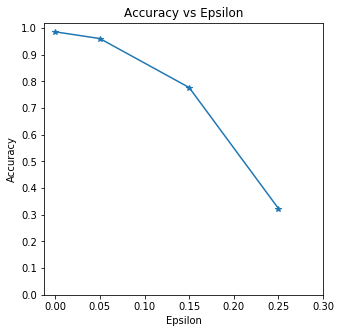

In [31]:
print('Blue: Raw ResNet under white-box attack.')
plt_acc_vs_eps(epsilons, accuracies)

## Sample Adversarial Examples  

Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.


In [32]:
def plt_examples(epsilons, examples):
    # Plot several examples of adversarial samples at each epsilon
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig,adv,ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

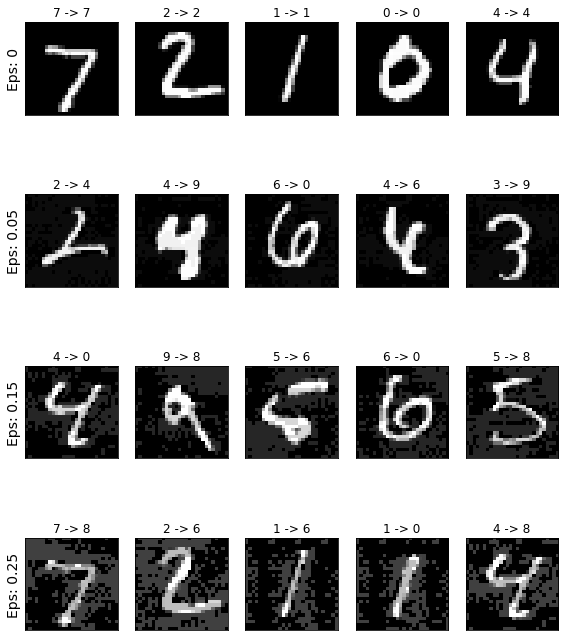

In [33]:
plt_examples(epsilons, examples)

# Defense   
The most popular defense in current research papers is probably adversarial training.  

## Adversarial Training  

The idea is to inject adversarial examples into training process and train the 
model either on adversarial examples or on mix of clean and adversarial examples.

Here, we use the training model to generate adversarial examples by FGSM attack and then 
feed them into the model.  
The perturbed image is get by this equation:  

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}  

We already have the raw image, and we can get the grad by one forward and backward pass. What we need here is 
`epsilon`. Since we need it to train a more robust model, we set `epsilon` equals to `0.3`. You can try different `epsilon` and see what happens.

<p style="color:red; font-weight:700; font-size: 20px;">Please try to finish the `fgsm_train` function.</p>

In [34]:
def fgsm_train(model, device, train_loader, optimizer, criterion, epoch, epsilon=0.3):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  
        data.requires_grad = True
        
        #****** To get the grad  *********
        # Forward pass
        output = model(data)  
        loss = criterion(output, target)  
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Collect datagrad
        sign_data_grad = torch.sign(data.grad.data)
        
        #****** Get perturbed_data  *********
        # Code here
        perturbed_data = data + epsilon * sign_data_grad
        
        # Note: Adding clipping to maintain [0,1] range  
        perturbed_data.clamp_(0.0, 1.0)  
        
        #****** Train model with perturbed_data  *********
        optimizer.zero_grad()
        pert_output = model(perturbed_data)
        pert_loss = criterion(pert_output, target)
        pert_loss.backward()  
        optimizer.step()   
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), pert_loss.item()))
        

In [35]:
def adv_main(save_name='./data/fgsm_adv_mnist_cnn.pt'):
    train_loader, test_loader = dataset_mnist()
    # Initialize the network
    model = resnet.ResNet18().to(device)
    
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs+1):
        fgsm_train(model, device, train_loader, optimizer,criterion, epoch)
        test(model, device, criterion, test_loader)
    
    # Save model
    torch.save(model.state_dict(), save_name)
    print('Model saved.')

<p style="color:red; font-weight:700; font-size: 20px;">Call the `adv_main` function to get a robust model.</p>

In [36]:
adv_resnet = './data/fgsm_adv_mnist_cnn.pt'
adv_main(adv_resnet)

Train Epoch: 1 [0/10000 (0%)]	Loss: 2.975379
Train Epoch: 1 [3200/10000 (32%)]	Loss: 1.261261
Train Epoch: 1 [6400/10000 (64%)]	Loss: 1.041582
Train Epoch: 1 [9600/10000 (96%)]	Loss: 0.599279

Test set: Average loss: 0.0894, Accuracy: 9787/10000 (98%)

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.449069
Train Epoch: 2 [3200/10000 (32%)]	Loss: 0.608407
Train Epoch: 2 [6400/10000 (64%)]	Loss: 0.403401
Train Epoch: 2 [9600/10000 (96%)]	Loss: 0.324470

Test set: Average loss: 0.0696, Accuracy: 9807/10000 (98%)

Train Epoch: 3 [0/10000 (0%)]	Loss: 0.111461
Train Epoch: 3 [3200/10000 (32%)]	Loss: 0.162235
Train Epoch: 3 [6400/10000 (64%)]	Loss: 0.223150
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.406694

Test set: Average loss: 0.0348, Accuracy: 9926/10000 (99%)

Model saved.


<p style="color:red; font-weight:700; font-size: 20px;">Repeat the test function and plot the figure of acc v.s. eps. and examples.</p>

In [37]:
re_accuracies, re_examples = attack_test(adv_resnet)
# Epsilon    Accuracy
#    0         ~raw  
#   0.05       <= ~98%  
#   0.15       <= ~98%  
#   0.25       <= ~95%

Pretrained Model ./data/fgsm_adv_mnist_cnn.pt
Epsilon: 0	Accuracy: 9926/10000 (99.26%)
Epsilon: 0.05	Accuracy: 9894/10000 (98.94%)
Epsilon: 0.15	Accuracy: 9793/10000 (97.93%)
Epsilon: 0.25	Accuracy: 9601/10000 (96.01%)


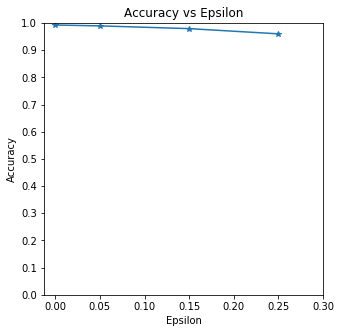

In [38]:
plt_acc_vs_eps(epsilons, re_accuracies)

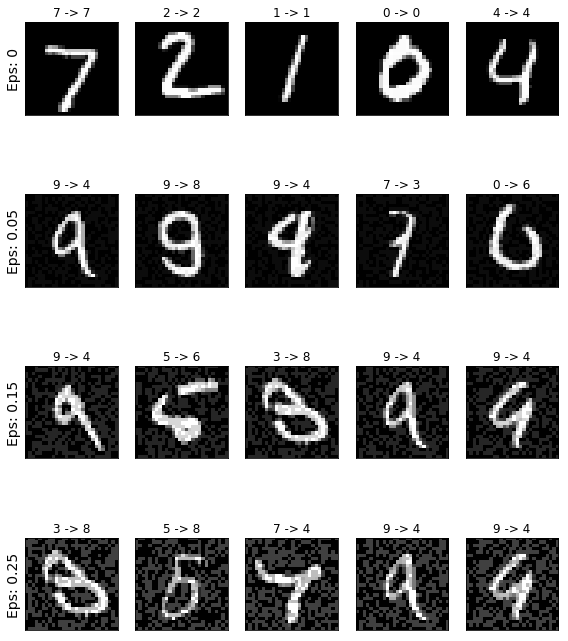

In [39]:
plt_examples(epsilons, re_examples)

In [40]:
def plt_comparion(epsilons, accs):
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accs[0], "*-")
    plt.plot(epsilons, accs[1], "*-", c='red')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

Blue: Raw ResNet under white-box attack.
Red : Robust ResNet under white-box attack.


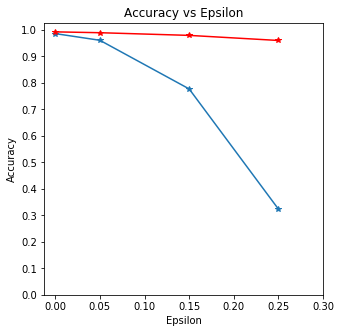

In [41]:
print('Blue: Raw ResNet under white-box attack.')
print('Red : Robust ResNet under white-box attack.')
plt_comparion(epsilons, [accuracies, re_accuracies])

## Asignment  

Try black-box attack using FGSM and test the robustness of adversarilly trained model.    

**Hints**:  
We've prepared the attack model——LeNet with the pretrained weight saved at 'data/minist_lenet.pt'.  

You need to finish the `black_box_attack` method and make some tests.

In [42]:
pretrained_lenet = 'data/mnist_lenet.pt'  # the attack model  

In [43]:
# LeNet Model definition  
class LeNet(nn.Module):
    def __init__(self):  
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  

In [44]:
def raw_train_lenet(save_name='./data/mnist_lenet.pt'):
    '''
    Main function to train and save the model under atttack.
    
    params:
        save_name: The model to be saved.
    '''
    train_loader, test_loader = dataset_mnist()
    # Initialize the network
    model = LeNet().to(device)
    
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    
    # Define the criterion 
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs+1):
        train(model, device, train_loader, optimizer, criterion, epoch)
        test(model, device, criterion, test_loader)
    
    # Save model
    torch.save(model.state_dict(), save_name)
    print('Model saved.')
    
# Uncomment the next line to train a new LeNet on yourself. The accuracy is about 97%.
# raw_train_lenet()
# Pay attentation to the learning rate compared with that in resnet.

<p style="color:red; font-weight:700; font-size: 20px;">Please finish the `black_box_attack` method.</p>  

**Hints:**  

You need to generate adversarial examples by the attacking model(pretrained lenet), and then use the 
adversarial examples to test the robustness of the defending model (raw resnet or adversarially trained resnet).  


In [45]:
def black_box_attack(attacker, defender, device, test_loader, epsilon):
    '''
    Use attacker model to generate adversarial examples. 
    And try to test the robustness of the defender.  
    '''
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the **attacker**
        
        
        # ********* Code here ****************
        output = attacker(data) # attacker or defender
        
        
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients of the attacker model
        attacker.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        
        # ********* Code here ****************
        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Use the defender to classify the perturbed image 
        output = defender(perturbed_data) # attacker or defender ?

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tAccuracy: {}/{} ({:.2f}%)".format(epsilon, correct, len(test_loader), 100.0 * final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [46]:
def black_box_attack_test(attacker_path, defender_path):
    '''
    
    
    '''
    attacker = LeNet().to(device)
    defender = resnet.ResNet18().to(device)
    # Load the pretrained model
    print('Pretrained Attack Model', attacker_path)
    attacker.load_state_dict(torch.load(attacker_path, map_location='cpu'))
    print('Pretrained Defend Model', defender_path)
    defender.load_state_dict(torch.load(defender_path, map_location='cpu'))
    # Set the model in evaluation mode. In this case this is for the Dropout layers
    attacker.eval()
    defender.eval() 
    
    _, test_loader = dataset_mnist()
    
    accuracies = []
    examples = []

    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = black_box_attack(attacker, defender, device, test_loader, eps)
        accuracies.append(acc)
        examples.append(ex)
    return accuracies, examples

In [47]:
pretrained_lenet = 'data/mnist_lenet.pt'  # the attack model  
raw_resnet = 'data/mnist_resnet.pt'        # raw resnet  
adv_resnet = 'data/fgsm_adv_mnist_cnn.pt'  # adversarially trained resnet

<p style="color:red; font-weight:700; font-size: 20px;">Please use the `black_box_attack_test` method to test the raw resnet model.</p>

In [48]:
raw_accs, raw_exs = black_box_attack_test(pretrained_lenet, raw_resnet)

Pretrained Attack Model data/mnist_lenet.pt
Pretrained Defend Model data/mnist_resnet.pt
Epsilon: 0	Accuracy: 9594/10000 (95.94%)
Epsilon: 0.05	Accuracy: 9526/10000 (95.26%)
Epsilon: 0.15	Accuracy: 9004/10000 (90.04%)
Epsilon: 0.25	Accuracy: 5266/10000 (52.66%)


<p style="color:red; font-weight:700; font-size: 20px;">Please use the `black_box_attack_test` method to test the adversarially trained resnet.</p>

In [49]:
adv_accs, adv_exs = black_box_attack_test(pretrained_lenet, adv_resnet)

Pretrained Attack Model data/mnist_lenet.pt
Pretrained Defend Model data/fgsm_adv_mnist_cnn.pt
Epsilon: 0	Accuracy: 9654/10000 (96.54%)
Epsilon: 0.05	Accuracy: 9650/10000 (96.50%)
Epsilon: 0.15	Accuracy: 9616/10000 (96.16%)
Epsilon: 0.25	Accuracy: 9364/10000 (93.64%)


Blue: Raw ResNet attacked by LeNet.
Red: Robust ResNet attacked by LeNet.


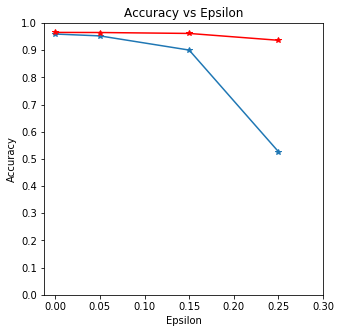

In [50]:
print('Blue: Raw ResNet attacked by LeNet.')
print('Red: Robust ResNet attacked by LeNet.')
plt_comparion(epsilons, [raw_accs, adv_accs])